In [1]:
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import numpy as np
import random
from SoccerWorld import player, game

In [2]:
def ce_action(qtable, player_state, rand_rate, num_actions, pi):

    if np.random.rand() < rand_rate:
        idx = np.random.choice(np.arange(25), 1)
        return np.array([idx // 5, idx % 5]).reshape(2)
    else:
#         print (np.sum(pi))
        idx = random.choices(np.arange(25), weights=pi)[0]
        return np.array([idx // 5, idx % 5]).reshape(2)

    return action


def lp(qtable1, qtable2, state):
    a = qtable1[state, :, :]
    b = qtable2[state, :, :]
    
    arr = np.zeros((a.shape[0]**2))
    z = np.zeros((a.shape[0]**2))
    for i in range(a.shape[0]):
        for j in range(a.shape[0]):
            if i != j:
                q = a[j] - a[i]
                n = i * (a.shape[0])
                arr[n:n+a.shape[0]] = q 
                z = np.vstack((z, arr))
                arr = np.zeros((a.shape[0]**2))
    # print (z)

    for i in range(b.shape[0]):
        for j in range(b.shape[0]):
            if i != j:
                l = np.transpose(np.array(range(a.shape[0]**2)).reshape(a.shape[0],a.shape[0])).reshape(a.shape[0]**2)  

                q = b[j] - b[i]
                n = i * (a.shape[0])
                for kk in range(q.shape[0]):
                    arr[l[kk]+i] = q[kk]

                z = np.vstack((z, arr))
                arr = np.zeros((a.shape[0]**2))
    G = np.delete(z, 0, axis=0)
    eye = np.eye(G.shape[1]) * -1
    G = np.vstack((G, eye))
    q = np.ones(a.shape[0]**2) * 1.
    G = np.vstack((G, q))
    q = np.ones(a.shape[0]**2) * -1.
    G = np.vstack((G, q))
    b = np.zeros((G.shape[0], 1))
    b[-2] = 1
    b[-1] = -1
#     print (G)
    c = np.zeros((a.shape[0] ** 2))
#     print (c)
#     print (b)
    c = matrix(c)    
    G = matrix(G)
    b = matrix(b)
    sol = solvers.lp(c,G,b, solver='glpk') 
    if sol['x'] is not None:
        probs = np.array(sol['x']).reshape(a.shape[0], a.shape[0])
        v1 = np.sum(probs * qtable1[state])
        v2 = np.sum(probs * qtable2[state])
        return probs, v1, v2
    else:
        return None, None, None

         
   
        

In [5]:
 
def ce_q_learning():
    
    errors = []
    qs = []
    #hyperparameters
    num_actions = 5
    num_rows = 2
    num_cols = 4
    num_states = num_rows * num_cols * 2 #2 is for possession
#     n = 1000000
    n = 1000000
    gamma = 0.9
    alpha = 0.5
    alpha_dec = 0.9999
    rar = 0.5
    radr = 0.99
    rand_rate = rar
    qtableA = np.zeros(shape=(num_states, num_actions, num_actions), dtype='float')
    qtableB = np.zeros(shape=(num_states, num_actions, num_actions), dtype='float')
    verbose = False
    
    
    V1 = np.ones(num_states) * 1.
    V2 = np.ones(num_states) * 1.
    
    pi = np.ones(shape=(num_states, num_actions**2)) * 1./25
    
    i = 0
    errors.append(0)
    qs.append(0)
    ind = []
    ind.append(0)
    while i < n:
        match = game(verbose=verbose, rows=2, columns=4, goalRstart=0, \
                     goalRend=1, aGoal=0, bGoal=3,aPosition=[0,2],\
                     bPosition=[0,1])
        
        initial_state = match.reset()
        
        state, score, done = match.move(4, 4)
        
        
        rand_rate *= radr
        
        if rand_rate < 0.05:
            rand_rate = 0.05
            


        while not done:

            old_state = state
            pA_act = ce_action(qtableA, state[0], rand_rate, num_actions, pi[state[0]])[0]
            pB_act = ce_action(qtableB, state[1], rand_rate, num_actions, pi[state[1]])[0]
            state, score, done = match.move(pA_act, pB_act)

   
                
            qtableA[old_state[0], pA_act, pB_act] = (1-alpha) * qtableA[old_state[0], pA_act, pB_act] + alpha * (score[0] + gamma * V1[state[0]])
            qtableB[old_state[1], pB_act, pA_act] = (1-alpha) * qtableB[old_state[1], pB_act, pA_act] + alpha * (score[1] + gamma * V2[state[1]])        

            probs, val1, val2 = lp(qtableA, qtableB, old_state[0])
            if probs is not None and val1 <= 100 and val1 >= -100 and val2 <= 100 and val2 >= -100:
                pi[old_state[0], :] = probs.reshape(25)
                V1[old_state[0]] = val1
                V2[old_state[1]] = val2

            
            if old_state[0] == 2 and pA_act == 1 and pB_act == 4:
                    
                error = abs(qtableA[2, 1, 4] - qs[-1])
                qs.append(qtableA[2,1,4])
                print (i, qtableA[2, 1, 4], error)
                errors.append(error)
                ind.append(i)
            if alpha < 0.001:
                alpha = 0.001
            alpha *= alpha_dec
            i += 1
        
        if i % 10000 == 0:
            print (i)
    return errors, ind
        

In [6]:
errr, ind = ce_q_learning()

48432 3.9811397128018264e-05 3.9811397128018264e-05
48594 7.882867996140375e-05 3.9017282833385485e-05
50000
50888 0.00011014947061231122 3.1320790650907475e-05
52400 0.00013711747015247115 2.6967999540159924e-05
53805 0.00016055141958575935 2.3433949433288205e-05
56958 0.00017735588350505408 1.6804463919294728e-05
57614 0.000193228720379489 1.587283687443493e-05
58469 0.00020748747224591074 1.4258751866421727e-05
59484 0.00022081650181167677 1.3329029565766035e-05
59717 0.00023339821944347457 1.2581717631797798e-05
60000
60061 0.00024554130555087545 1.2143086107400882e-05
60394 0.00025771780419372553 1.2176498642850074e-05
60537 0.0002697213079813738 1.2003503787648276e-05
60558 0.00028169581836749486 1.1974510386121053e-05
61008 0.0002931721532409121 1.1476334873417255e-05
61032 0.0003046119465632042 1.1439793322292106e-05
61364 0.00031568554931096993 1.1073602747765714e-05
61601 0.0003265313158268782 1.084576651590825e-05
62046 0.0003369382634779975 1.0406947651119328e-05
62132 0.00

105150 0.0019571466218989177 1.3662015311002688e-05
105592 0.0019708304438211146 1.368382192219698e-05
105641 0.0019845005832897712 1.367013946865659e-05
105962 0.0019983462570275293 1.3845673737758035e-05
105991 0.0020121203296924444 1.3774072664915135e-05
106008 0.0020259299655556074 1.3809635863162948e-05
106174 0.0020397882958236423 1.3858330268034982e-05
106292 0.0020536835840068877 1.3895288183245376e-05
107278 0.0020680428878472757 1.4359303840387992e-05
108355 0.002082732609974552 1.46897221272764e-05
108787 0.0020977932507866433 1.5060640812091224e-05
108961 0.0021129596655376235 1.5166414750980139e-05
109235 0.0021282380155305475 1.5278349992924045e-05
109267 0.0021435010887013136 1.5263073170766056e-05
109321 0.0021586688572079247 1.5167768506611171e-05
109797 0.0021741123786597 1.544352145177539e-05
110000
110467 0.002189726671530751 1.5614292871050928e-05
110627 0.0022054841433992974 1.575747186854633e-05
111341 0.0022221263435087493 1.6642200109451884e-05
112783 0.0022388

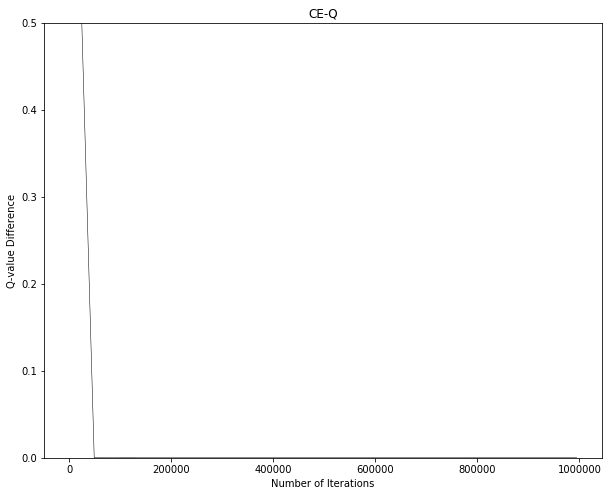

In [8]:
errr[0] = 1

plt.figure('Q-Learning')
plt.clf()
plt.title('CE-Q')
plt.xlabel('Number of Iterations')
plt.ylabel('Q-value Difference')
plt.ylim(0, 0.5)
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(ind, errr, linestyle='-', color='black', linewidth=0.5)
plt.savefig('CE-Q.png')